<a href="https://colab.research.google.com/github/aborundiya/CNN/blob/master/CIFAR_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch 
import numpy as np 
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms 
import torch.nn as nn 
import torch.optim as optim
from torchvision import models
import copy 

#Checkign the GPU availability

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


#Loading the dataset and transforming

In [0]:
transform_train = transforms.Compose([
                                      transforms.RandomResizedCrop(244),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5),(0.5, 0.5,0.5))
])

transform_test  = transforms.Compose([
                                      transforms.RandomResizedCrop(244),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

In [5]:
train_set = torchvision.datasets.CIFAR10('./data',train=True,download=True,transform=transform_train)
test_set = torchvision.datasets.CIFAR10('./data',train=False,transform=transform_test)

Extracting ./data/cifar-10-python.tar.gz to ./data


#Visualization 

In [6]:
num_classes = 10
batch_size = 4 
train_dataloader = torch.utils.data.DataLoader(train_set,batch_size=batch_size,shuffle=True)
images , labels = iter(train_dataloader).next()
print(images.shape)

torch.Size([4, 3, 244, 244])


In [0]:
def imshow(img, title):
  nimg = img.numpy() / 2 + 0.5 
  plt.figure(figsize=(batch_size,1))
  plt.axis("off")
  plt.imshow(np.transpose(nimg,(1,2,0)))
  plt.title(title)
  plt.show()

In [0]:
def show_batch_images(dataloader):
  images, labels = iter(dataloader).next()
  img = torchvision.utils.make_grid(images)
  imshow(img, title=[str(x.item()) for x in labels ])

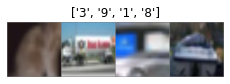

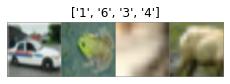

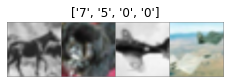

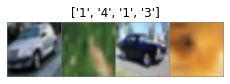

In [9]:
for i in range(4):
  show_batch_images(train_dataloader)

#loading the ResNet pretrained model

In [0]:
batch_size = 16 
train_loader = torch.utils.data.DataLoader(train_set,batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=batch_size,shuffle=False)


In [11]:
resnet = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [12]:
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
for param in resnet.parameters():
  param.requires_grad = False 



In [0]:
final_in_feature = resnet.fc.in_features
resnet.fc = nn.Linear(final_in_feature,num_classes)

In [15]:
for param in resnet.parameters():
  if param.requires_grad:    
    print(param.shape)

torch.Size([10, 512])
torch.Size([10])


In [0]:
def evaluation(dataloader, model):
  total , correct = 0 , 0 
  for data in dataloader:

    inputs, labels = data 
   
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    
    _ , pred = torch.max(outputs.data,1)
    
    total += labels.size(0)
    correct += (pred == labels).sum().item()
  return 100 * (correct / total )


In [0]:
resnet = resnet.to(device)


In [0]:
loss_fn = nn.CrossEntropyLoss()
lr = [0.1,0.01,0.001,0.0001]
weight_decay = [0.0001, 0.001]
function = [optim.SGD, optim.Adam, optim.Adagrad, optim.RMSprop]

for i in range(len(lr)):
  for j in range(len(weight_decay)):
    for k in range(len(function)):
      opt = function[k](resnet.parameters(),lr=lr[i], weight_decay=weight_decay[j])
      #optim.SGD(resnet.parameters(),lr=0.01,momentum=0.9,nesterov=True)
      loss_arr = []
      loss_arr_epoch = []
      max_epoch = 2 
      n_iter = np.ceil(50000/batch_size)
      print(function[k])
      print("For weight decay : %f and For learning Rate : %f:" % (weight_decay[j], lr[i]))
      min_loss = 1000

      for epoch in range(max_epoch):
        for l , data in enumerate(train_loader,0):
          inputs, labels = data 
          inputs, labels = inputs.to(device), labels.to(device)
          opt.zero_grad()
          outputs = resnet(inputs)
          loss = loss_fn(outputs,labels)
          loss.backward()
          opt.step()
          if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(resnet.state_dict())
            #print("Min Loss %0.2f"% min_loss)
          #if l % 100 == 0 : 
            #print("Epoch %d/%d, Loss : %0.2f"  % (l, n_iter,loss.item()))
          
          del inputs, labels, outputs 
          torch.cuda.empty_cache()
        loss_arr_epoch.append(loss.item())
        resnet.load_state_dict(best_model)
        print("Epoch %d/%d , Test Accuracy : %0.2f , Train Accuracy : %0.2f" % (epoch, max_epoch, evaluation(test_loader,resnet), evaluation(train_loader,resnet)))


In [0]:
resnet.load_state_dict(best_model)
print(evaluation(train_loader, resnet), evaluation(test_loader, resnet))